_Stefano Maxenti - maxenti.s@northeastern.edu_

# EECE 7398: Verifiable Machine Learning -- Fall 2023
# HW#2: Formal Verification

**Submission Instructions:** Please upload a .ipynb file (including your code, plots, and written answers) to Gradescope. This file can be updated unlimited times until the submission deadline.

The goal of this assignment is to give you hands-on experience with formal verification of neural networks. You will code some verification algorithms from scratch in the first few problems to build an understanding of how these concepts from class actually play out in code. Then, you will get to use some libraries to gain familiarity with state-of-the-art software in this research field.

You're welcome to use PyTorch, TensorFlow, Keras, or other appropriate libraries to help make your life easier throughout the problems - we tried to make the function signatures somewhat framework-agnostic.

For this assignment, we'll use the [NNet](https://github.com/sisl/nnet) format as a language/framework-agnostic description of a ReLU network and its parameters. Here are some possibly useful functions that convert between nnet, numpy arrays, and pytorch models (feel free to use these or not).

In [1]:
import torch
import numpy as np
import cvxpy as cp
from enum import Enum
import matplotlib.pyplot as plt

In [2]:
def nnet_to_weights_and_biases(nnet_filename: str) -> tuple[np.ndarray, np.ndarray]:
  # load a nnet text file and extract the weights and biases

  # converted this code from: https://github.com/sisl/NeuralVerification.jl/blob/957cb32081f37de57d84d7f0813f708288b56271/src/utils/util.jl#L10
  with open(nnet_filename, 'r') as f:
    line = f.readline()
    while "//" in line: #skip comments
      line = f.readline()
    # number of layers
    nlayers = int(line.strip().split(",")[0])
    # read in layer sizes
    layer_sizes = [int(x) for x in f.readline().split(",")[1:nlayers+1]]
    # read past additonal information
    for i in range(1, 6):
      line = f.readline()
    # i=1 corresponds to the input dimension, so it's ignored
    Ws = []
    bs = []
    for dim in layer_sizes:
      W = np.vstack([[float(x) for x in f.readline().rstrip(',\n ').split(",")] for i in range(dim)])
      b = np.array([float(f.readline().rstrip(',\n ')) for _ in range(dim)])
      Ws.append(W)
      bs.append(b)

  return Ws, bs

def weights_and_biases_to_pytorch(Ws: list[np.ndarray], bs: list[np.ndarray]) -> torch.nn.Sequential:
  # given weights and biases, create a torch.nn.Sequential model with relus
  # btwn each linear layer (except no activation on final layer)

  num_layers = len(Ws)

  layers = []
  for W, b in zip(Ws, bs):
    out_features, in_features = W.shape
    layer = torch.nn.Linear(in_features, out_features)
    layer.weight = torch.nn.Parameter(torch.Tensor(W))
    layer.bias = torch.nn.Parameter(torch.Tensor(b))
    layers.append(layer)
    layers.append(torch.nn.ReLU())

  # don't add ReLU to end of NN
  model = torch.nn.Sequential(*layers[:-1])
  return model

def nnet_to_pytorch(nnet_filename: str) -> torch.nn.Sequential:
  # directly convert from nnet text file to pytorch model
  Ws, bs = nnet_to_weights_and_biases(nnet_filename)
  model = weights_and_biases_to_pytorch(Ws, bs)
  return model

def model_to_weights_and_biases(model: torch.nn.Sequential) -> tuple[np.ndarray, np.ndarray]:
  # extract the weights and biases as numpy arrays from a torch.nn.Sequential model
  Ws = []
  bs = []
  for idx, m in enumerate(model.modules()):
    if isinstance(m, torch.nn.Sequential):
      continue
    elif isinstance(m, torch.nn.ReLU):
      continue
    elif isinstance(m, torch.nn.Linear):
      Ws.append(m.weight.data.numpy())
      bs.append(m.bias.data.numpy())
    else:
      print("That layer isn't supported.")
      assert 0
  return Ws, bs

In [3]:
def nominal_and_epsilon_to_range(nominal: np.ndarray, epsilon: np.ndarray | float) -> np.ndarray:
  return np.vstack([nominal-epsilon, nominal+epsilon]).T

def range_to_nominal_and_epsilon(input_range: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
  nominal_input = (input_range[:, 1] + input_range[:, 0]) / 2.
  epsilon = (input_range[:, 1] - input_range[:, 0]) / 2.
  return nominal_input, epsilon

For example, to load a NN controller for a cartpole system, then query the controller for its action at a particular state:

In [4]:
print("Cartpole Controller")

# Load the NNet file and pass a nominal input to get the class logits
nnet_filename = "cartpole_nnet.nnet"
nominal_input = torch.Tensor([[0., 0.1, 0.2, 0.3]]) # these 4 values correspond to the 4 states in cartpole
model = nnet_to_pytorch(nnet_filename)
Ws, bs = model_to_weights_and_biases(model)
nominal_output = model(nominal_input)
print(f"{nominal_output=}")

# Also set up an example set of possible inputs to this NN
epsilon = 0.1 # epsilon can be a scalar or a vec w/ same shape as nominal_input
input_range = nominal_and_epsilon_to_range(nominal_input, epsilon)
print(f"{input_range=}")

Cartpole Controller
nominal_output=tensor([[12.9007, -1.4208]], grad_fn=<AddmmBackward0>)
input_range=array([[-0.1       ,  0.1       ],
       [ 0.        ,  0.2       ],
       [ 0.1       ,  0.3       ],
       [ 0.20000002,  0.4       ]], dtype=float32)


Let's start by viewing the structure of the cartpole model using Pythorch.

In [5]:
print(model)

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=16, bias=True)
  (5): ReLU()
  (6): Linear(in_features=16, out_features=2, bias=True)
)


# Problem 1: Sampling-Based Under-Approximations [DONE]

One way to approximate the set of possible NN outputs for a given set of possible NN inputs is by exhaustively sampling. Here, you will implement a simple sampling-based method for estimating the min and max values for each dimension of the NN output. This sampling-based strategy provides an under-approximation of the output set (and the corresponding rectangular bound is an under-approximation of the axis-aligned bounding box around the true output set).

The cartpole NN only has 4 inputs and 2 outputs, so you can visualize its output samples easily.

**Deliverables**:

- Implement the `output_range_sampling` function
- For the cartpole NN, plot your output samples and the corresponding rectangular bounds for a few different values of `num_samples`


In [6]:
def output_range_sampling(nnet_filename: str, input_range: np.ndarray, num_samples: int) -> np.ndarray:

  # Getting weights and biases
  Ws, bs = nnet_to_weights_and_biases(nnet_filename)
  m = weights_and_biases_to_pytorch(Ws, bs)
  Ws, bs = model_to_weights_and_biases(m)
  model = nnet_to_pytorch(nnet_filename)

  output_per_sample = []
  last_layer = []
  for i in range(num_samples):
    l = []

    # creating the 4 random inputs in the range
    for _ in range(0,input_range.shape[0]):
      l.append(np.random.uniform(input_range[_, :].min(),input_range[_, :].max()))

    input_sample = np.array(l)
    output_per_layer = []
    weight_index = 0

    for i in range(0, len(model)):

      if isinstance(model[i], torch.nn.Linear):
        output = np.dot(Ws[weight_index], input_sample)+bs[weight_index]
        weight_index+=1
      elif isinstance(model[i], torch.nn.ReLU):
        output = np.clip(input_sample, a_min=0, a_max=None)
      if i == len(model)-1:
        last_layer.append(output)

      input_sample = output
      output_per_layer.append(output)

    output_per_sample.append(output_per_layer)


  return output_per_sample, last_layer

In [7]:
def plot_random_sample(last_layer, lw=5, with_value=True):
  # Plotting the rectangular bounds
  # Initialize variables to store the bounds
  x_min = float('inf')
  x_max = float('-inf')
  y_min = float('inf')
  y_max = float('-inf')
  # Iterate through the points and update the bounds
  for x, y in last_layer:
      x_min = min(x_min, x)
      x_max = max(x_max, x)
      y_min = min(y_min, y)
      y_max = max(y_max, y)

  x = [x_min, x_min, x_max, x_max, x_min]
  y = [y_min, y_max, y_max, y_min, y_min]
  plt.plot(x,y,marker='o', lw=lw, label="Sampling")
  if with_value:
    for l in last_layer:
      plt.plot(l[0], l[1], 'b.')

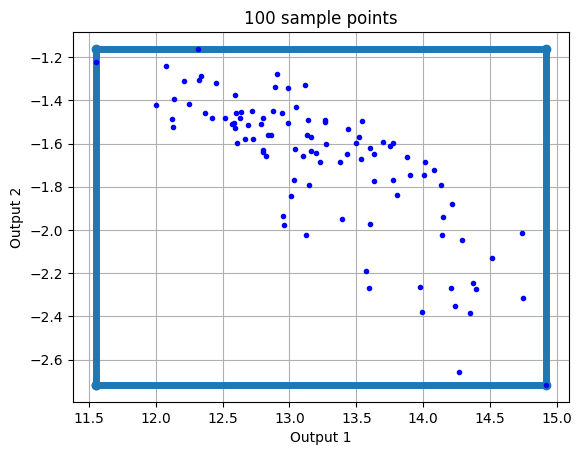

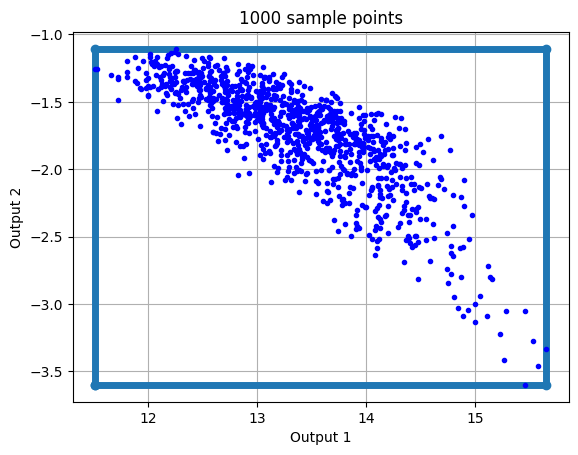

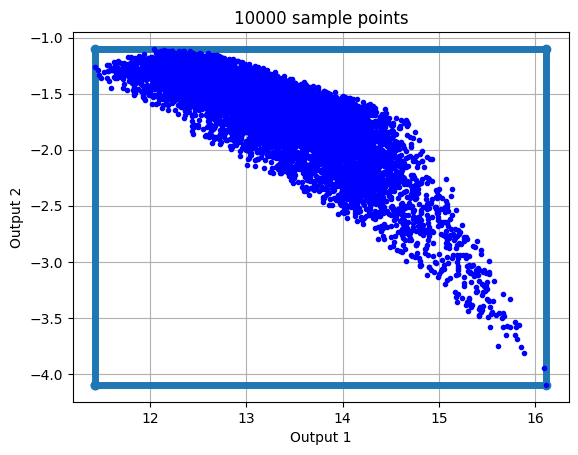

In [8]:
for num_samples in [1e2, 1e3, 1e4]:
  complete_output, last_layer = output_range_sampling(nnet_filename, input_range, int(num_samples))
  plot_random_sample(last_layer)
  plt.grid()
  plt.title('Random sampling')
  plt.xlabel('Output 1')
  plt.ylabel('Output 2')
  title = str(int(num_samples))+" sample points"
  plt.title(title)
  plt.show()

In [9]:
random_sample_final_result = last_layer

# Problem 2: Interval Bound Propagation (IBP) [DONE]

Now, you will implement the IBP algorithm to get *outer* bounds on the output set -- which are much more useful for proving that the NN will not produce undesired outputs. You may want to read [the IBP paper](https://arxiv.org/pdf/1810.12715.pdf) (especially around Eqn 6) to help with this.

**Deliverables:**

- Implement the `verify_ibp` function
- Print the `output_range` from your IBP implementation
- Plot your IBP rectangular bounds along with the samples from above to see how ridiculously loose IBP bounds can be

I implement the IBP algorithm following eq. 6 and eq. 7 from the paper.

In [10]:
def verify_ibp(nnet_filename: str, input_range: np.ndarray) -> np.ndarray:

  # Getting weights and biases
  Ws, bs = nnet_to_weights_and_biases(nnet_filename)
  m = weights_and_biases_to_pytorch(Ws, bs)
  Ws, bs = model_to_weights_and_biases(m)
  model = nnet_to_pytorch(nnet_filename)

  # Creating the empty lists for the IBP formulation
  u = []
  r = []
  z_up =[]
  z_dw = []

  # Initialization: z0 = x0 +- epsilon
  z_dw.append(input_range[:,0])
  z_up.append(input_range[:,1])

  # Ws has shape 4, the length of the model is 7 (Linear+ReLUs),
  # weight_index is used in the affine linear layer for weights and biases.
  weight_index = 0
  list_results = []
  for i in range(0, len(model)):
    # Affine linear layer
    if isinstance(model[i], torch.nn.Linear):
      # calculating {u,r}_(k-1)
      u.append((z_up[-1]+z_dw[-1])/2)
      r.append((z_up[-1]-z_dw[-1])/2)
      # calculating {u,r}_k
      u.append(np.dot(Ws[weight_index], u[-1])+bs[weight_index])
      r.append(np.dot(np.absolute(Ws[weight_index]), r[-1]))
      # calculating {z_dw, z_up}_k
      z_dw.append(u[-1]-r[-1])
      z_up.append(u[-1]+r[-1])
      # increasing the index for the future linear layer
      weight_index += 1

    # ReLU activation: in this case, I don't need to use eq.6 but eq.7
    # therefore just the activation
    elif isinstance(model[i], torch.nn.ReLU):
      # ReLU(x) = {x if x > 0, 0 otherwise}
      z_dw.append(np.clip(z_dw[-1], a_min=0, a_max=None))
      z_up.append(np.clip(z_up[-1], a_min=0, a_max=None))

    # Results need to be reshaped
    result = np.vstack((z_dw[-1], z_up[-1])).T
    list_results.append(result)

  return list_results, result

In [11]:
list_results, output_range_ibp = verify_ibp(nnet_filename, input_range)
print(f"output bounds via IBP (custom): \n{output_range_ibp}")

output bounds via IBP (custom): 
[[-25.6073    52.51912 ]
 [-32.457947  23.750446]]


In [12]:
def plot_rectangle(bounds, alg, lw=5):
  min_output1 = min(bounds[0])
  max_output1 = max(bounds[0])
  min_output2 = min(bounds[1])
  max_output2 = max(bounds[1])
  x = [min_output1, min_output1, max_output1, max_output1, min_output1]
  y = [min_output2, max_output2, max_output2, min_output2, min_output2]
  plt.plot(x,y,marker='o', lw=lw, label=alg)

def plot_pretty_graph(title):
  plt.legend()
  plt.grid()
  plt.xlabel('Output 1')
  plt.ylabel('Output 2')
  plt.title(title)
  plt.show()

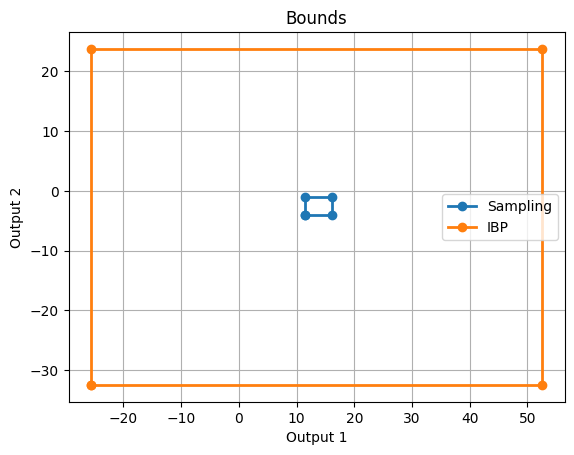

In [13]:
plot_random_sample(random_sample_final_result, with_value=False, lw=2)
plot_rectangle(output_range_ibp, alg="IBP", lw=2)
plot_pretty_graph("Bounds")

IBP is definitely looser than sampling...

# Problem 3: Linear Program (LP) [DONE]

Since IBP's bounds are usually too loose to say something useful about the NN's output set, you will now implement an LP-based verification algorithm that should provide much tighter bounds while remaining computationally reasonable.

You will set up an LP (e.g., using `cvxpy` to set up variables, constraints, and objectives corresponding to the NN verification problem) for each side of the rectangle (i.e., min & max per output dimension, which can be done by simply changing the objective). To turn the ReLU constraints into linear equality/inequality constraints, you can check which neurons are "active", "inactive", or "uncertain" and add the corresponding relaxed constraints. To know which neurons belong to which category, you will need to acquire intermediate bounds -- there are lots of ways to do this!

**Planet (triangle) relaxation**

I start by implementing the relaxation introduced by Rüdiger Ehlers in "Formal Verification of Piece-Wise Linear Feed-Forward Neural Networks".

The uncertain ReLU neuron is codified as follows:

$$d ≥ 0$$
$$d ≥ c$$
$$d ≤ \frac{u(c-l)}{u-l}$$

where, in our case, c is the output of the previous linear layer (c = Wx+b) and d is the output of the ReLU.

Verification of the accuracy of this function with a real library is performed later in the `jax_verify` section.

In [14]:
def verify_lp_triangle(nnet_filename: str, input_range: np.ndarray) -> np.ndarray:

  ibp_list, final_ibp = verify_ibp(nnet_filename, input_range)
  ibp_boxes = [input_range]+ibp_list

  Ws, bs = nnet_to_weights_and_biases(nnet_filename)
  m = weights_and_biases_to_pytorch(Ws, bs)
  Ws, bs = model_to_weights_and_biases(m)
  constraints = []

  input_variables = []
  # linear variables, eventually, becomes the set of all variables
  linear_variables = []
  relu_variables_y = []

  weight_index = 0

  # I start from -1 to account the input layer which is not integrated in the model.
  for i in range(-1, len(model)):

    if i == -1: # input layer
      input_variables.append(cp.Variable((input_range.shape[0],1))) # in the cartpole case, (4,1)
      lower = ibp_boxes[0][:,[0]] # lower of the IBP
      upper = ibp_boxes[0][:,[1]] # upper of the IBP
      constraints.extend([ input_variables[-1] <= upper, input_variables[-1] >= lower])
      linear_variables.append(input_variables[-1]) # it becomes easier for the second linear layer

    elif isinstance(model[i], torch.nn.Linear): # any linear layer
      linear_variables.append(cp.Variable((Ws[weight_index].shape[0],1)))
      # z_i = W_i * x_i + b_i
      constraints.extend([linear_variables[-1] == (Ws[weight_index]@ linear_variables[-2] + bs[weight_index].reshape(-1,1))])
      weight_index += 1 # next element in Ws

    elif isinstance(model[i], torch.nn.ReLU):
      lower = ibp_boxes[i][:,[0]]
      upper = ibp_boxes[i][:,[1]]
      relu_variables_y.append(cp.Variable((Ws[weight_index-1].shape[0],1)))
      # Whereas before I was able to compute all values in matrix forms, here I have to go neuron per neuron.
      for j in range(Ws[weight_index-1].shape[0]): # -1 because we increment the value of weight_index at the end of each linear layer
        lb = lower[j]
        ub = upper[j]
        if (lb <= 0) & (ub <= 0): # ReLU is definitely 0
          constraints.extend([relu_variables_y[-1][j] == 0])
        elif (lb>0) & (ub>0): # ReLU is definitely the same as x
          constraints.extend([relu_variables_y[-1][j] == linear_variables[-1][j]])
        else: # ReLU could be anything, applying the triangle relaxation as described in the paper
          constraints.extend([  relu_variables_y[-1][j] >= 0,
                                relu_variables_y[-1][j] >= linear_variables[-1][j],
                                relu_variables_y[-1][j] <= cp.multiply(ub, linear_variables[-1][j]-lb) / (ub-lb) ])
      linear_variables.append(relu_variables_y[-1]) # appending the final ReLU to the linear variables as to be called in the next layer


  lower_bound = []
  upper_bound = []

  for i in range(linear_variables[-1].shape[0]):
    lower_obj = cp.Problem(cp.Minimize(linear_variables[-1][i]), constraints).solve()
    lower_bound.append(linear_variables[-1].value[i].item())
    upper_obj = cp.Problem(cp.Maximize(linear_variables[-1][i]), constraints).solve()
    upper_bound.append(linear_variables[-1].value[i].item())

  output_range = np.vstack((lower_bound, upper_bound)).T
  return output_range

In [15]:
output_range_lp_triangle = verify_lp_triangle(nnet_filename, input_range)
print(output_range_lp_triangle)

[[  0.49762228  25.70728041]
 [-11.84320978   5.98689269]]


**MILP approach.**

In this case, I use the MILP encoding, where the uncertain ReLU is codified as:

$$y≤x-l\cdot(1-a)$$
$$y≥x$$
$$y≤u\cdot{a}$$
$$y≥0$$
$$a\in{0,1}$$

In [16]:
def verify_lp(nnet_filename: str, input_range: np.ndarray) -> np.ndarray:

  ibp_list, final_ibp = verify_ibp(nnet_filename, input_range)
  ibp_boxes = [input_range]+ibp_list

  Ws, bs = nnet_to_weights_and_biases(nnet_filename)
  m = weights_and_biases_to_pytorch(Ws, bs)
  Ws, bs = model_to_weights_and_biases(m)
  constraints = []

  input_variables = []
  # linear variables, eventually, becomes the set of all variables but a
  linear_variables = []
  relu_variables_y = []
  relu_variables_a = [] # the boolean list of variables


  weight_index = 0

  # I start from -1 to account the input layer which is not integrated in the model.
  for i in range(-1, len(model)):
    if i == -1: # input layer
      input_variables.append(cp.Variable((input_range.shape[0],1))) # in this case, (4,1)
      lower = ibp_boxes[0][:,[0]] # lower of the IBP
      upper = ibp_boxes[0][:,[1]] # upper of the IBP
      constraints.extend([ input_variables[-1] <= upper, input_variables[-1] >= lower])
      linear_variables.append(input_variables[-1]) # it becomes easier for the second linear layer
    elif isinstance(model[i], torch.nn.Linear): # any linear layer
      linear_variables.append(cp.Variable((Ws[weight_index].shape[0],1)))
      # z_i = W_i * x_i + b_i
      constraints.extend([linear_variables[-1] == (Ws[weight_index]@ linear_variables[-2] + bs[weight_index].reshape(-1,1))])
      weight_index += 1 # next element in Ws

    elif isinstance(model[i], torch.nn.ReLU):
      lower = ibp_boxes[i][:,[0]]
      upper = ibp_boxes[i][:,[1]]
      relu_variables_y.append(cp.Variable((Ws[weight_index-1].shape[0],1)))
      relu_variables_a.append(cp.Variable((Ws[weight_index-1].shape[0],1), boolean=True)) # the variable a is only boolean
      # Whereas before I was able to compute all values in matrix forms, here I have to go neuron per neuron.
      for j in range(Ws[weight_index-1].shape[0]): # -1 because we increment the value of weight_index at the end of each linear layer
        lb = lower[j]
        ub = upper[j]
        if (lb <= 0) & (ub <= 0): # ReLU is definitely 0
          constraints.extend([ relu_variables_a[-1][j] == 0, relu_variables_y[-1][j] == 0])
        elif (lb>0) & (ub>0): # ReLU is definitely the same as x
          constraints.extend([ relu_variables_a[-1][j] == 1, relu_variables_y[-1][j] == linear_variables[-1][j]])
        else: # ReLU could be anything, applying the exact MILP encoding as on the slides
          constraints.extend([  relu_variables_y[-1][j] <= linear_variables[-1][j] - cp.multiply(lb, (1-relu_variables_a[-1][j])) ,
                                relu_variables_y[-1][j] >= linear_variables[-1][j],
                                relu_variables_y[-1][j] <= cp.multiply(ub, relu_variables_a[-1][j]),
                                relu_variables_y[-1][j] >= 0 ])
      linear_variables.append(relu_variables_y[-1]) # appending the final ReLU to the linear variables as to be called in the next layer


  lower_bound = []
  upper_bound = []

  for i in range(linear_variables[-1].shape[0]):
    lower_obj = cp.Problem(cp.Minimize(linear_variables[-1][i]), constraints).solve()
    lower_bound.append(linear_variables[-1].value[i].item())
    upper_obj = cp.Problem(cp.Maximize(linear_variables[-1][i]), constraints).solve()
    upper_bound.append(linear_variables[-1].value[i].item())

  output_range = np.vstack((lower_bound, upper_bound)).T
  return output_range

In [17]:
output_range_lp_milp = verify_lp(nnet_filename, input_range)
print(output_range_lp_milp)

[[11.16606096 16.43648271]
 [-4.37983591 -1.08750905]]


Let's start by drawing a quick comparison between MILP and Triangle.

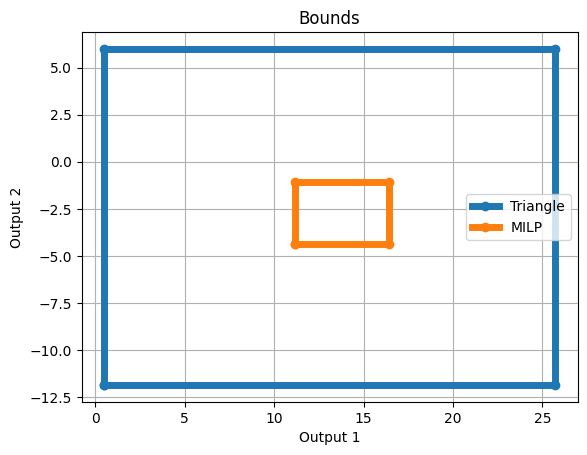

In [18]:
plot_rectangle(output_range_lp_triangle, alg="Triangle")
plot_rectangle(output_range_lp_milp, alg="MILP")
plot_pretty_graph("Bounds")

We can see that MILP is much more bounded than Triangle and it makes sense, since triangle is a relaxation method.

Now let's compare MILP and Sampling.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


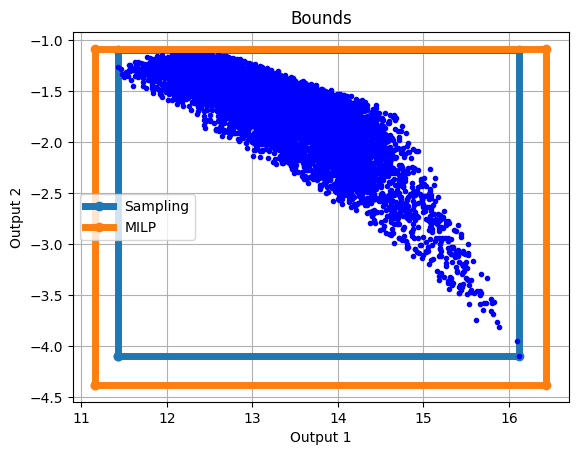

In [19]:
plot_random_sample(random_sample_final_result, with_value=True)
plot_rectangle(output_range_lp_milp, alg="MILP")
plot_pretty_graph("Bounds")

The MILP is a bit looser than the sampling, but I believe it comes from the randomness of the sampling. The looser bounds are where there are fewer datapoints.

And finally a comparison of bounds of all algorithms so far.

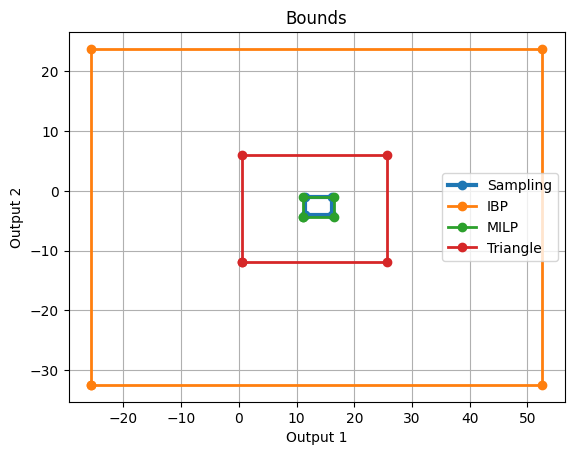

In [20]:
plot_random_sample(random_sample_final_result, with_value=False, lw=3)
plot_rectangle(output_range_ibp, alg='IBP', lw=2)
plot_rectangle(output_range_lp_milp, alg="MILP", lw=2)
plot_rectangle(output_range_lp_triangle, alg="Triangle", lw=2)
plot_pretty_graph("Bounds")

# Problem 4: Verify Classifier Robustness [DONE]

So far, you have written verification algorithms that provide upper and lower bounds on each output of the NN. Here, you will slightly modify your LP verifier so that it verifies the *robustness* of a *classifier* (i.e., prove that the classifier predicts the same class for every input within some range).

If the verification algorithm is able to prove robustness, you should return `VerifierResults.Robust`. If the verification algorithm is unable to prove robustness, you should return `VerifierResults.Unsure` (remember that this doesn't necessarily mean the classifier isn't robust, just that our algorithm failed to find a proof). I also added a `VerifierResults.Timeout` option, because you will often see this in real verification algorithms, but you do not need to use this here.

To start, you can pretend the cartpole controller was a classifier and try to see how large of an epsilon you can specify until you can't verify the robustness anymore.

Then, you can load an MNIST classifier (code below) and try to see how large of an epsilon for which you can still verify robustness around a nominal image. Since the MNIST classifier is a way bigger NN, there will be some impact on the runtime of your LP.

**Deliverables:**

- Implement `verify_classification_robustness_lp`
- Plot and/or briefly describe your findings w.r.t. robustness verification as you increase epsilon for the cartpole controller
- Plot and/or briefly describe your findings w.r.t. robustness verification as you increase epsilon for the MNIST classifier

Let's start with the **cartpole**.

In [21]:
class VerifierResults(Enum):
  Robust = 0
  Unsure = 1
  Timeout = 2 # not used

def verify_classification_robustness_lp(nnet_filename: str, input_range: np.ndarray, nominal_input: np.ndarray) -> np.ndarray:
  ## from here to ...
  ibp_list, final_ibp = verify_ibp(nnet_filename, input_range)
  ibp_boxes = [input_range]+ibp_list

  Ws, bs = nnet_to_weights_and_biases(nnet_filename)
  m = weights_and_biases_to_pytorch(Ws, bs)
  Ws, bs = model_to_weights_and_biases(m)
  model = nnet_to_pytorch(nnet_filename)
  constraints = []

  input_variables = []
  # linear variables, eventually, becomes the set of all variables but a
  linear_variables = []
  relu_variables_y = []
  relu_variables_a = [] # the boolean list of variables

  # quick hack to fix the wrong output dimension between the two models.
  if nnet_filename == 'mnist1.nnet':
    result = model(nominal_input).detach_().numpy()
  else:
    result = model(nominal_input).detach_().numpy()[0]

  weight_index = 0
  #print(ibp_boxes)
  # I start from -1 to account the input layer which is not integrated in the model.
  for i in range(-1, len(model)):
    if i == -1: # input layer
      input_variables.append(cp.Variable((input_range.shape[0],1))) # in this case, (4,1)
      lower = ibp_boxes[0][:,[0]] # lower of the IBP
      upper = ibp_boxes[0][:,[1]] # upper of the IBP
      constraints.extend([ input_variables[-1] <= upper, input_variables[-1] >= lower])
      linear_variables.append(input_variables[-1]) # it becomes easier for the second linear layer
    elif isinstance(model[i], torch.nn.Linear): # any linear layer
      linear_variables.append(cp.Variable((Ws[weight_index].shape[0],1)))
      # z_i = W_i * x_i + b_i
      constraints.extend([linear_variables[-1] == (Ws[weight_index]@ linear_variables[-2] + bs[weight_index].reshape(-1,1))])
      weight_index += 1 # next element in Ws

    elif isinstance(model[i], torch.nn.ReLU):
      lower = ibp_boxes[i][:,[0]]
      upper = ibp_boxes[i][:,[1]]
      relu_variables_y.append(cp.Variable((Ws[weight_index-1].shape[0],1)))
      relu_variables_a.append(cp.Variable((Ws[weight_index-1].shape[0],1), boolean=True)) # the variable a is only boolean
      # Whereas before I was able to compute all values in matrix forms, here I have to go neuron per neuron.
      for j in range(Ws[weight_index-1].shape[0]): # -1 because we increment the value of weight_index at the end of each linear layer
        lb = lower[j]
        ub = upper[j]
        if (lb <= 0) & (ub <= 0): # ReLU is definitely 0
          constraints.extend([ relu_variables_a[-1][j] == 0, relu_variables_y[-1][j] == 0])
        elif (lb>0) & (ub>0): # ReLU is definitely the same as x
          constraints.extend([ relu_variables_a[-1][j] == 1, relu_variables_y[-1][j] == linear_variables[-1][j]])
        else: # ReLU could be anything, applying the exact MILP encoding as on the slides
          constraints.extend([  relu_variables_y[-1][j] <= linear_variables[-1][j] - cp.multiply(lb, (1-relu_variables_a[-1][j])) ,
                                relu_variables_y[-1][j] >= linear_variables[-1][j],
                                relu_variables_y[-1][j] <= cp.multiply(ub, relu_variables_a[-1][j]),
                                relu_variables_y[-1][j] >= 0 ])
      linear_variables.append(relu_variables_y[-1]) # appending the final ReLU to the linear variables as to be called in the next layer
  ## ... here is the same as the LP verifier with MILP.

  # this is the argmax real class
  target_class = np.argmax(result)

  print("Original target_class: ", target_class)

  for i in range(linear_variables[-1].shape[0]):
    if target_class == i:
      # no need to check class i with class i
      continue
    else:
      if result[target_class]>=result[i]:
        obj = cp.Problem(cp.Minimize((linear_variables[-1][target_class]-linear_variables[-1][i])), constraints).solve()
      else:
        obj = cp.Problem(cp.Minimize(-(linear_variables[-1][target_class]-linear_variables[-1][i])), constraints).solve()
    if obj >= 0:
      print("Robust against class", i)
    else:
      print("Unsure against class", i)
      return VerifierResults.Unsure # no need to continue

  return VerifierResults.Robust # we have tried all combinations

In [22]:
list_epsilon = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

for epsilon in list_epsilon:
  print("Epsilon: ", epsilon)
  input_range = nominal_and_epsilon_to_range(nominal_input, epsilon)
  output_range_lp = verify_classification_robustness_lp(nnet_filename, input_range, nominal_input)
  print(output_range_lp, "\n\n")

Epsilon:  0.5
Original target_class:  0
Robust against class 1
VerifierResults.Robust 


Epsilon:  0.6
Original target_class:  0
Robust against class 1
VerifierResults.Robust 


Epsilon:  0.7
Original target_class:  0
Unsure against class 1
VerifierResults.Unsure 


Epsilon:  0.8
Original target_class:  0
Unsure against class 1
VerifierResults.Unsure 


Epsilon:  0.9
Original target_class:  0
Unsure against class 1
VerifierResults.Unsure 


Epsilon:  1
Original target_class:  0
Unsure against class 1
VerifierResults.Unsure 




So, 0.7 seems the maximum perturbation allowed before the sign of the objective function becomes negative (and therefore our hyphotetical binary classifier is wrong).

Load a NN classifier for **MNIST**, then query the model at a particular image:

In [23]:
print("MNIST Classifier")

# Load the NNet file and pass a nominal input to get the class logits
nnet_filename_mnist = "mnist1.nnet"

from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_index = 2 # this one should be correctly classified as a 4...
nominal_input_mnist = torch.Tensor(x_train[img_index].flatten())
model_mnist = nnet_to_pytorch(nnet_filename_mnist)
Ws_mnist, bs_mnist = model_to_weights_and_biases(model_mnist)
nominal_output = model_mnist(nominal_input_mnist)
nominal_class = nominal_output.argmax()
print(f"{nominal_output=}")
print(f"Predicted Class: {nominal_class}, True Class: {y_train[img_index]}")

MNIST Classifier
11490434/11490434 [==============================] - 0s 0us/step
nominal_output=tensor([ -130.8385, -1543.3896,   131.6747,   348.4880,   987.1154, -1114.0826,
         -638.6053,   216.2303,   -85.5050,   418.8903],
       grad_fn=<AddBackward0>)
Predicted Class: 4, True Class: 4


In [24]:
# Also set up an example set of possible inputs to this NN
epsilon_mnist_list = [1, 2, 3, 4, 4.2, 4.5]
for e in epsilon_mnist_list:
  epsilon_mnist = e*np.ones((784))
  input_range_mnist = nominal_and_epsilon_to_range(nominal_input_mnist, epsilon_mnist)
  #print(f"{input_range_mnist=}")
  print("Epsilon: ", e)

  verifier_result = verify_classification_robustness_lp(nnet_filename_mnist, input_range_mnist, nominal_input_mnist)
  print(verifier_result, "\n")

Epsilon:  1
Original target_class:  4
Robust against class 0
Robust against class 1
Robust against class 2
Robust against class 3
Robust against class 5
Robust against class 6
Robust against class 7
Robust against class 8
Robust against class 9
VerifierResults.Robust 

Epsilon:  2
Original target_class:  4
Robust against class 0
Robust against class 1
Robust against class 2
Robust against class 3
Robust against class 5
Robust against class 6
Robust against class 7
Robust against class 8
Robust against class 9
VerifierResults.Robust 

Epsilon:  3
Original target_class:  4
Robust against class 0
Robust against class 1
Robust against class 2
Robust against class 3
Robust against class 5
Robust against class 6
Robust against class 7
Robust against class 8
Robust against class 9
VerifierResults.Robust 

Epsilon:  4
Original target_class:  4
Robust against class 0
Robust against class 1
Robust against class 2
Robust against class 3
Robust against class 5
Robust against class 6
Robust against

The code correctly finds whether the epsilon put as perturbation to the specific input yields to a misclassified output, in this case at around epsilon=4.2.

# Problem 5: Explore the `jax_verify` library for verification [DONE]

There are a few excellent open-source libraries for NN verification. For example, `jax_verify` has implementations of IBP, CROWN, and many other algorithms. These methods can handle a broader class of NNs than just the ReLU NNs you worked with above, so they may be useful tools to leverage in your research or projects.

A big upside of `jax_verify` is that it supports JIT compilation, which can speed up verification algorithms by 10-100x (you don't need to set up JIT compilation for this assignment, but you're encouraged to try that out if you're curious).

Note that the `jax_verify` that is available by default in PyPi is an old version from 2020 that has a slightly different API - installing a more recent version is recommended as we do below.

In [25]:
# Install my fork of jax_verify, which fixes a few deprecation errors in the mainline repo
!pip install git+https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify

  Cloning https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify to /tmp/pip-req-build-7i47ww1b
  Running command git clone --filter=blob:none --quiet https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify /tmp/pip-req-build-7i47ww1b
  Resolved https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify to commit e7377591821f35b479aa89c7ac2ca0adb5c5415d
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/deepmind/einshape.git to /tmp/pip-install-zc_vdgi9/einshape_93e64380f6dc4ed9b65535b12e2ea3d3
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/einshape.git /tmp/pip-install-zc_vdgi9/einshape_93e64380f6dc4ed9b65535b12e2ea3d3
  Resolved https://github.com/deepmind/einshape.git to commit d91ab136da3d97f4ba2b4582531cdc2dfd9fab0a
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.3/360.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.9 MB/s et

In [26]:
import jax.numpy as jnp
import jax_verify
import functools

Loading the cartpole again.

In [27]:
print("Cartpole Controller")

# Load the NNet file and pass a nominal input to get the class logits
nnet_filename = "cartpole_nnet.nnet"
nominal_input = torch.Tensor([[0., 0.1, 0.2, 0.3]]) # these 4 values correspond to the 4 states in cartpole
model = nnet_to_pytorch(nnet_filename)
Ws, bs = model_to_weights_and_biases(model)
nominal_output = model(nominal_input)
print(f"{nominal_output=}")

# Also set up an example set of possible inputs to this NN
epsilon = 0.1 # epsilon can be a scalar or a vec w/ same shape as nominal_input
input_range = nominal_and_epsilon_to_range(nominal_input, epsilon)
print(f"{input_range=}")

Cartpole Controller
nominal_output=tensor([[12.9007, -1.4208]], grad_fn=<AddmmBackward0>)
input_range=array([[-0.1       ,  0.1       ],
       [ 0.        ,  0.2       ],
       [ 0.1       ,  0.3       ],
       [ 0.20000002,  0.4       ]], dtype=float32)


Some utility methods that help set up the NN in jax:

In [28]:
def pytorch_model_to_jax(torch_model: torch.nn.Sequential):
  params = []
  act = None

  # Extract params (weights, biases) from torch layers, to be used in
  # jax.
  # Note: This propagator assumes a feed-forward relu NN.
  for m in torch_model.modules():
    if isinstance(m, torch.nn.Sequential):
      continue
    elif isinstance(m, torch.nn.ReLU):
      if act is None or act == "relu":
        act = "relu"
    elif isinstance(m, torch.nn.Linear):
      w = m.weight.data.numpy().T
      b = m.bias.data.numpy()
      params.append((w, b))
  return functools.partial(relu_nn, params)

def relu_nn(params, inputs):
  for W, b in params[:-1]:
    outputs = jnp.dot(inputs, W) + b
    inputs = jnp.maximum(outputs, 0)
  W, b = params[-1]
  return jnp.dot(inputs, W) + b

def jax_interval_to_np_range(interval: jax_verify.IntervalBound) -> np.ndarray:
  return np.vstack([interval.lower, interval.upper]).T

def np_range_to_jax_interval(input_range: np.ndarray) -> jax_verify.IntervalBound:
  return jax_verify.IntervalBound(input_range[:, 0], input_range[:, 1])

jax_model = pytorch_model_to_jax(model)

An example of using `jax_verify`'s implementation of IBP on our cartpole control NN

In [29]:
# Example of a fwd pass on the NN using jax
nominal_output_jax = jax_model(jnp.array(nominal_input))

# Example of computing bounds using IBP as implemented by jax_verify
input_bounds = np_range_to_jax_interval(input_range)
output_bounds_ibp_jax = jax_verify.interval_bound_propagation(
    jax_model, input_bounds)
output_range_ibp_jax = jax_interval_to_np_range(output_bounds_ibp_jax)
print(f"output bounds via IBP (jax_verify): \n{output_range_ibp_jax}")

output bounds via IBP (jax_verify): 
[[-25.607307  52.51912 ]
 [-32.457947  23.750446]]


Does that output match the output of your IBP implementation?

**YES! It matches! :-)**

Now for your job: take a look at `jax_verify`'s documentation to see how to use the backward CROWN verifier.

**Deliverables:**

- output bounds using backward CROWN, rather than IBP

According to the documentation, backward CROWN is very simple to calculate importing the specific function.

The bounds are much smaller that the one found by IBP, meaning that backward CROWN is more suited for this kind of verification.

In [30]:
output_bounds_crown_jax = jax_verify.backward_crown_bound_propagation(
    jax_model, input_bounds)
output_bounds_crown_jax = jax_interval_to_np_range(output_bounds_crown_jax)
print(f"output bounds via backward Crown Bound (jax_verify): \n{output_bounds_crown_jax}")

output bounds via backward Crown Bound (jax_verify): 
[[10.74421    17.722935  ]
 [-4.760766   -0.22639704]]


**Planet (triangle)**

I would like to check if my implementaion of the triangle relaxation is actually correct using `jax_verify`.

The structure of the verification comes from https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify/-/blob/master/examples/run_lp_solver.py?ref_type=heads

In [31]:
## WITH jax_verify library
# creating the partial model
logits_fn = functools.partial(jax_model)

# Using jax_verify IBP method after reshaping the input in the right size
init_bound = jax_verify.IntervalBound( np.reshape(input_range[:, 0], (1,4)), np.reshape(input_range[:, 1], (1,4) ))
# Always using IBP for the range.
boundprop_transform = jax_verify.ibp_transform

# This is the real ouput of the model without any perturbation.
dummy_output = jax_model(jnp.array(nominal_input))

# Run LP solver, selecting the right objective values
objective = jnp.where(jnp.arange(dummy_output[0, ...].size) == 0,
                      jnp.ones_like(dummy_output[0, ...]),
                      jnp.zeros_like(dummy_output[0, ...]))

objective_bias = 0
# magic happens
value, _, status = jax_verify.solve_planet_relaxation(
    logits_fn, init_bound, boundprop_transform, objective,
    objective_bias, index=0)
print('Relaxation LB is:', -value)
value, _, status = jax_verify.solve_planet_relaxation(
    logits_fn, init_bound, boundprop_transform, -objective,
    objective_bias, index=0)
print('Relaxation UB is:', -value)
# Run LP solver
objective = jnp.where(jnp.arange(dummy_output[0, ...].size) == 0,
                      jnp.zeros_like(dummy_output[0, ...]),
                      jnp.ones_like(dummy_output[0, ...]))
objective_bias = 0
value, _, status = jax_verify.solve_planet_relaxation(
    logits_fn, init_bound, boundprop_transform, objective,
    objective_bias, index=0)
print('Relaxation LB is:', value)
value, _, status = jax_verify.solve_planet_relaxation(
    logits_fn, init_bound, boundprop_transform, -objective,
    objective_bias, index=0)
print('Relaxation UB is:', -value)

Relaxation LB is: -0.49762148224496316
Relaxation UB is: 25.707281262048113
Relaxation LB is: -11.84321028280922
Relaxation UB is: 5.9868937713701404


**Indeed, results are the same.**

# Problem 6: Explore the `auto-LiRPA` library for verification [DONE]

`auto-LiRPA` is a verification library based on PyTorch and one of the main developers was a Northeastern PhD student (Kaidi Xu)!

Just like with the previous problem, the next cells show you how to install the package and run IBP, then we ask you to look into their documentation and run backward CROWN on the same problem.

**Note:** I suggest doing this part last, because pip may try to downgrade the version of pytorch installed to satisfy requirements. You may also need to restart your kernel after the pip install. If you're on Colab and things seem messed up, you can always do `Runtime > Disconnect and delete runtime` (stronger than restarting the runtime, which doesn't reset to the default set of installed packages).

In [ ]:
!pip install auto-lirpa

  Using cached auto_LiRPA-0.3-py3-none-any.whl (163 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 736.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.2/510.2 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.1/275.1 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2+cu118
    Uninstalling torchvision-0.15.2+cu118:
      Successfully uninstalled torchvision-0.15.2+cu118
ERROR: pip's depen

An example of using `auto-LiRPA`'s implementation of IBP on our cartpole control NN:

_(I copied all the original code below so that it can be run linearly without going back and forth)_

In [ ]:
import torch
import numpy as np
import cvxpy as cp
from enum import Enum
import matplotlib.pyplot as plt

def nnet_to_weights_and_biases(nnet_filename: str) -> tuple[np.ndarray, np.ndarray]:
  # load a nnet text file and extract the weights and biases

  # converted this code from: https://github.com/sisl/NeuralVerification.jl/blob/957cb32081f37de57d84d7f0813f708288b56271/src/utils/util.jl#L10
  with open(nnet_filename, 'r') as f:
    line = f.readline()
    while "//" in line: #skip comments
      line = f.readline()
    # number of layers
    nlayers = int(line.strip().split(",")[0])
    # read in layer sizes
    layer_sizes = [int(x) for x in f.readline().split(",")[1:nlayers+1]]
    # read past additonal information
    for i in range(1, 6):
      line = f.readline()
    # i=1 corresponds to the input dimension, so it's ignored
    Ws = []
    bs = []
    for dim in layer_sizes:
      W = np.vstack([[float(x) for x in f.readline().rstrip(',\n ').split(",")] for i in range(dim)])
      b = np.array([float(f.readline().rstrip(',\n ')) for _ in range(dim)])
      Ws.append(W)
      bs.append(b)

  return Ws, bs

def weights_and_biases_to_pytorch(Ws: list[np.ndarray], bs: list[np.ndarray]) -> torch.nn.Sequential:
  # given weights and biases, create a torch.nn.Sequential model with relus
  # btwn each linear layer (except no activation on final layer)

  num_layers = len(Ws)

  layers = []
  for W, b in zip(Ws, bs):
    out_features, in_features = W.shape
    layer = torch.nn.Linear(in_features, out_features)
    layer.weight = torch.nn.Parameter(torch.Tensor(W))
    layer.bias = torch.nn.Parameter(torch.Tensor(b))
    layers.append(layer)
    layers.append(torch.nn.ReLU())

  # don't add ReLU to end of NN
  model = torch.nn.Sequential(*layers[:-1])
  return model

def nnet_to_pytorch(nnet_filename: str) -> torch.nn.Sequential:
  # directly convert from nnet text file to pytorch model
  Ws, bs = nnet_to_weights_and_biases(nnet_filename)
  model = weights_and_biases_to_pytorch(Ws, bs)
  return model

def model_to_weights_and_biases(model: torch.nn.Sequential) -> tuple[np.ndarray, np.ndarray]:
  # extract the weights and biases as numpy arrays from a torch.nn.Sequential model
  Ws = []
  bs = []
  for idx, m in enumerate(model.modules()):
    if isinstance(m, torch.nn.Sequential):
      continue
    elif isinstance(m, torch.nn.ReLU):
      continue
    elif isinstance(m, torch.nn.Linear):
      Ws.append(m.weight.data.numpy())
      bs.append(m.bias.data.numpy())
    else:
      print("That layer isn't supported.")
      assert 0
  return Ws, bs

def nominal_and_epsilon_to_range(nominal: np.ndarray, epsilon: np.ndarray | float) -> np.ndarray:
  return np.vstack([nominal-epsilon, nominal+epsilon]).T

def range_to_nominal_and_epsilon(input_range: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
  nominal_input = (input_range[:, 1] + input_range[:, 0]) / 2.
  epsilon = (input_range[:, 1] - input_range[:, 0]) / 2.
  return nominal_input, epsilon

print("Cartpole Controller")

# Load the NNet file and pass a nominal input to get the class logits
nnet_filename = "cartpole_nnet.nnet"
nominal_input = torch.Tensor([[0., 0.1, 0.2, 0.3]]) # these 4 values correspond to the 4 states in cartpole
model = nnet_to_pytorch(nnet_filename)

epsilon = 0.1 # epsilon can be a scalar or a vec w/ same shape as nominal_input
input_range = nominal_and_epsilon_to_range(nominal_input, epsilon)

Cartpole Controller


In [ ]:
from auto_LiRPA import BoundedModule, BoundedTensor, PerturbationLpNorm

# Wrap the model with auto_LiRPA.
model = BoundedModule(model, torch.Tensor(nominal_input))
# Define perturbation. Here we add Linf perturbation to input data.
ptb = PerturbationLpNorm(norm=np.inf, eps=torch.Tensor([epsilon]))
# Make the input a BoundedTensor with the pre-defined perturbation.
my_input = BoundedTensor(torch.Tensor(nominal_input), ptb)
# Regular forward propagation using BoundedTensor works as usual.
prediction = model(my_input)
# Compute LiRPA bounds using IBP
lb, ub = model.compute_bounds(x=(my_input,), method="ibp")
output_range_ibp_autolirpa = np.vstack([lb.detach().numpy(), ub.detach().numpy()]).T
print(f"output bounds via IBP (auto-lirpa): \n{output_range_ibp_autolirpa}")

output bounds via IBP (auto-lirpa): 
[[-25.607302  52.51912 ]
 [-32.457947  23.750443]]


Does that match your implementation of IBP? What about `jax_verify`'s?

**My `custom IBP implementation`, the versions from `jax_verify` and from `auto-LiRPA` coincide!**

Now for your job: compute output bounds using `auto-LiRPA`'s implementation of backward CROWN

**Deliverables:**

- output bounds using backward CROWN, rather than IBP

According to the documentation, backward CROWN is very simple to calculate importing the specific function.

The bounds are much smaller that the one found by IBP, meaning that backward CROWN is more suited for this kind of verification.

In [ ]:
lb, ub = model.compute_bounds(x=(my_input,), method='CROWN')
output_range_crown_autolirpa = np.vstack([lb.detach().numpy(), ub.detach().numpy()]).T
print(f"output bounds via backward CROWN: \n{output_range_crown_autolirpa}")

output bounds via backward CROWN: 
[[10.744209   17.722933  ]
 [-4.7607675  -0.22639656]]


*And, of course, `jax_verify` and `auto-LiRPA` provide the same bounds for backward CROWN.*

**CONCLUSIONS**

To wrap everything up, a comparison of all the methods is shown now.

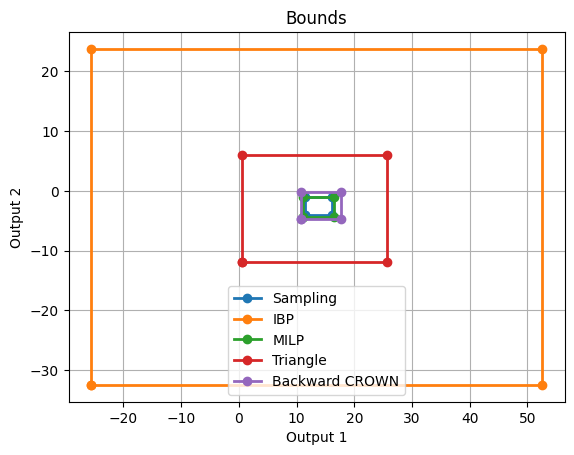

In [32]:
plot_random_sample(random_sample_final_result, with_value=False, lw=2)
plot_rectangle(output_range_ibp, alg='IBP', lw=2)
plot_rectangle(output_range_lp_milp, alg="MILP", lw=2)
plot_rectangle(output_range_lp_triangle, alg="Triangle", lw=2)
plot_rectangle(output_bounds_crown_jax, alg="Backward CROWN", lw=2)
plot_pretty_graph("Bounds")

All done!